In [1]:
#Anirrudh Ramesh Nov 20 2020
import time
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import numpy as np
from tensorflow . python . training . moving_averages \
import assign_moving_average
from scipy . stats import multivariate_normal as normal

from tensorflow . python . ops import control_flow_ops
from tensorflow import random_normal_initializer as norm_init
from tensorflow import random_uniform_initializer as unif_init
from tensorflow import constant_initializer as const_init

In [35]:
class framework(object):
    """The fully - connected neural network model."""
    def __init__(self, sess):
        self.sess = sess
    # parameters for the function we want to approximate
        self.domain_bound = 150   # boundary value M
        self.terminal_time = 1
        
    # parameters for the algorithm
        self.n_simple_train1 = 425 # number samples in training set 
        self.n_simple_train2 = 300
        self.n_simple_train3 = 300
        self.n_simple_valid = 2000 # number samples in validation set

        self.hidden_neuron = 50  #number of neurons in each layer 
        self.n_neuron = [1, self.hidden_neuron, self.hidden_neuron, 1] 
        #structure of of neural net
        
    
        self.n_maxstep = 200000 # number of maximum iteration
        self.n_displaystep = 100 # every n_displaystep steps, we output some information
        self.picdisplaystep= 200 # every picdisplaystep steps, we output graph
        self.learning_rate = 5e-3
        
        # some basic constants and variables
        self._extra_train_ops = []
        self.tolerence = 5e-4
        
    def train(self):
        start_time = time.time()
        trainable_vars = tf.trainable_variables()
        grads = tf.gradients(self.loss, trainable_vars)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        apply_op = \
                optimizer.apply_gradients(zip(grads, trainable_vars))
        train_ops = [apply_op] + self._extra_train_ops
        self.train_op = tf.group(* train_ops)

        self.loss_history = []
        self.time_history = []
        
#=============================================================================
# You can change the code in this block if needed. But make sure always feed 
# neural net what it needs. 
        x_valid1 = self.sample_point_X1(self.n_simple_valid)
        x_valid2 = self.sample_point_X2(self.n_simple_valid)
        x_valid3 = self.sample_point_X3(self.n_simple_valid)
        feed_dict_valid = {self.Xi: x_valid1, self.Xb: x_valid2, self.Xt: x_valid3, self.is_training: False}
#=============================================================================
        print("before initialized")
        
        # initialization
        step = 1
        self.sess.run(tf.global_variables_initializer())
        temp_loss = self.sess.run(self.loss,
                                  feed_dict = feed_dict_valid)
        self.loss_history.append(temp_loss)
        self.time_history.append(0)
        
        print("step: %5u, loss: %.4e," % \
              (0, temp_loss))
        
        #x_test_gradient = np.array([[0],[1],[2],[3]])
        #gradient_test = self.sess.run(self.gradient_test,
                                     #feed_dict = {self.X: x_test_gradient,
                                                 #self.is_training: False})
        
        # begin sgd iteration
        # for iii in range (self.n_maxstep + 2):
        while (self.loss_history[-1] > self.tolerence) and (step < self.n_maxstep) :
             x_train1 = self.sample_point_X1(self.n_simple_train1)
             x_train2 = self.sample_point_X2(self.n_simple_train2)
             x_train3 = self.sample_point_X3(self.n_simple_train3)
             self.sess.run(self.train_op,
                           feed_dict = {self.Xi: x_train1, self.Xb: x_train2, self.Xt: x_train3,
                                       self.is_training: True})
             if step % self.n_displaystep == 0:
                 temp_loss = self.sess.run(self.loss,
                                           feed_dict = feed_dict_valid)
                 self.loss_history.append(temp_loss)
                 self.time_history.append(time.time() - start_time + self.t_bd)
                 print ("step: %5u, loss: %.4e, time: %5u" % \
                        (step , temp_loss, time.time() - start_time))

             #if step % self .picdisplaystep == 0:
                     #approximate_f = self.sess.run(self.output,
                                                   #feed_dict = feed_dict_valid)                     
                     #plt.scatter(x_valid, approximate_f, label = 'approximation of neural net')
                     #plt.scatter(x_valid, self.f(x_valid), label = 'real function f')
                     #plt.legend()
                     #plt.show()
             step += 1

        x1 = [[0, 100], [1, 90], [1, 80], [1, 110]]
        self.outputsample = self.sess.run(self.output, 
                                          feed_dict = {self.Xi: x1, self.Xb: x_valid2, 
                                                       self.Xt: x_valid3, self.is_training: False})
#=============================================================================        
# You will need to rewrite this block. 
    def build(self):
        start_time = time.time()
        self.Xi = tf.placeholder(tf.float64, [None, 2], name = 'Xi') # interior
        self.Xb = tf.placeholder(tf.float64, [None, 2], name = 'Xb') # boundary
        self.Xt = tf.placeholder(tf.float64, [None, 2], name = 'Xt') # terminal
        self.is_training = tf.placeholder(tf.bool)
        
# the variable f_ is output of neural net given certain input.       
        c_interior = self._one_time_net(self.Xi, 'c')[:,0]
        c_boundary = self._one_time_net(self.Xb, 'c')[:,0]
        c_terminal = self._one_time_net(self.Xt, 'c')[:,0]
        
# loss function here is just L2 norm of difference of this two function.
        c_interior_dt = tf.gradients(c_interior, self.Xi)[0][:,0]
        c_interior_dx = tf.gradients(c_interior, self.Xi)[0][:,1]
        c_interior_dxx = tf.gradients(c_interior_dx, self.Xi)[0][:,1]
        c_boundary_dx = tf.gradients(c_boundary, self.Xb)[0][:,1]
        
        loss_terminal = c_terminal - tf.math.maximum(self.Xt[:,1]-90, 0)
        loss_boundary = c_boundary_dx - 1
        loss_interior = c_interior_dt + 0.01*tf.math.multiply(self.Xi[:,1], c_interior_dx) 
        + 0.5*0.04*tf.math.multiply(tf.math.square(self.Xi[:,1]), c_interior_dxx) - 0.01*c_interior
    
        self.loss = tf.reduce_mean((loss_terminal)**2) + tf.reduce_mean((loss_boundary)**2) + tf.reduce_mean((loss_interior)**2)
        
# test of tf.gradient function
        #self.gradient_test = tf.gradients(self.f(self.X), self.X)
#=============================================================================  
        self.output = c_interior
        self.t_bd = time.time() - start_time        
        print('end of build')
#=============================================================================        
# this function define how we sample points in domain
    def sample_point_X1(self, n_sample1): #interior
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample1, 1))
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample1, 1))
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X2(self, n_sample2): # boundary x=M
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample2, 1))
        x = np.ones((n_sample2, 1)) * self.domain_bound
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X3(self, n_sample3): # terminal t=T
        t = np.ones((n_sample3, 1)) * self.terminal_time
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample3, 1))
        X = np.hstack((t, x))
        X
        return X
    
# this is the function we want to approximate
#    def f(self, x):
#        return x**3
    
# you can change number of layer or activation function if needed
    def _one_time_net(self, x, name):
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            layer1 = self._one_layer(x, self.n_neuron[1], activation_fn = tf.nn.elu, name = 'layer1')
            layer2 = self._one_layer(layer1, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            layer3 = self._one_layer(layer2, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            u = self._one_layer(layer3, self.n_neuron[3], activation_fn = None ,name ='final')
        return u

# you can change initialization of weight in each layer if needed
    def _one_layer(self, input_, out_sz,
                   activation_fn = None,
                   std =1.0, name = 'linear'):
        with tf.variable_scope(name,):
            shape = input_.get_shape().as_list()
            w = tf.get_variable('Matrix',
                                [shape[1], out_sz], tf.float64,
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1] + out_sz)))
            hidden = tf.matmul(input_, w)
        if activation_fn != None:
            return activation_fn(hidden)
        else:
            return hidden

#if __name__ == '__main__ ':
#    np.random.seed(1)
#    main()
#main()

with tf.Session(graph=tf.Graph()) as sess:
    tf.set_random_seed(1)
    print("begin to solve approximation")
    model = framework(sess)
    model.build()
    model.train()
    output = np.zeros((len(model.loss_history), 3))
    output[:,0] = np.arange(len(model.loss_history)) \
    * model.n_displaystep
    output[:,1] = model.loss_history
    output[:,2] = model.time_history
    outputsample = model.outputsample
    print(outputsample)

begin to solve approximation
end of build
before initialized
step:     0, loss: 4.6399e+02,
step:   100, loss: 6.1844e+00, time:     1
step:   200, loss: 1.8112e-01, time:     2
step:   300, loss: 3.3167e-01, time:     2
step:   400, loss: 3.1772e-02, time:     3
step:   500, loss: 6.1607e-02, time:     4
step:   600, loss: 2.0642e-02, time:     5
step:   700, loss: 1.6130e-02, time:     6
step:   800, loss: 5.8673e-02, time:     6
step:   900, loss: 1.2456e-01, time:     7
step:  1000, loss: 1.7092e-02, time:     8
step:  1100, loss: 2.2557e-01, time:     9
step:  1200, loss: 6.6608e-01, time:    10
step:  1300, loss: 1.4885e-02, time:    10
step:  1400, loss: 5.1758e-02, time:    11
step:  1500, loss: 1.1212e-02, time:    12
step:  1600, loss: 1.3982e-01, time:    13
step:  1700, loss: 2.4900e-02, time:    14
step:  1800, loss: 1.0663e-02, time:    15
step:  1900, loss: 4.4203e-02, time:    16
step:  2000, loss: 1.2866e-02, time:    16
step:  2100, loss: 1.1972e-02, time:    17
step:

step: 19000, loss: 1.5671e-01, time:   156
step: 19100, loss: 1.2135e-03, time:   156
step: 19200, loss: 8.1219e-04, time:   157
step: 19300, loss: 2.4079e-03, time:   158
step: 19400, loss: 2.2792e-01, time:   159
step: 19500, loss: 3.1843e-03, time:   160
step: 19600, loss: 1.3759e-03, time:   160
step: 19700, loss: 1.0041e-03, time:   161
step: 19800, loss: 3.1487e-03, time:   162
step: 19900, loss: 2.7604e-03, time:   163
step: 20000, loss: 1.0327e-03, time:   164
step: 20100, loss: 9.3020e-04, time:   164
step: 20200, loss: 1.8160e-02, time:   165
step: 20300, loss: 1.2342e-03, time:   166
step: 20400, loss: 9.0783e-04, time:   167
step: 20500, loss: 7.0117e-01, time:   168
step: 20600, loss: 1.9771e-03, time:   168
step: 20700, loss: 2.9667e-02, time:   169
step: 20800, loss: 1.5020e-02, time:   170
step: 20900, loss: 1.2289e-03, time:   171
step: 21000, loss: 1.1515e-03, time:   172
step: 21100, loss: 2.8686e-03, time:   172
step: 21200, loss: 1.4515e-02, time:   173
step: 21300

step: 38100, loss: 1.4087e-03, time:   309
step: 38200, loss: 9.5053e-02, time:   310
step: 38300, loss: 1.0676e-03, time:   310
step: 38400, loss: 9.4000e-04, time:   311
step: 38500, loss: 1.8359e-03, time:   312
step: 38600, loss: 4.3205e-02, time:   313
step: 38700, loss: 4.6599e-03, time:   313
step: 38800, loss: 1.2248e-03, time:   314
step: 38900, loss: 1.2333e-03, time:   315
step: 39000, loss: 9.6020e-04, time:   316
step: 39100, loss: 4.8598e-02, time:   317
step: 39200, loss: 4.6758e-02, time:   317
step: 39300, loss: 1.1585e-03, time:   318
step: 39400, loss: 6.6246e-04, time:   319
step: 39500, loss: 5.3914e-04, time:   320
step: 39600, loss: 4.7608e-04, time:   321
[10.99362494  0.03459251  0.         19.99030746]


Text(0, 0.5, 'Convergence rate (time)')

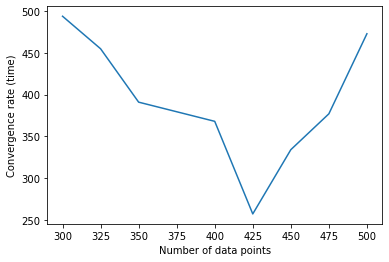

In [36]:

x = [500,475 ,450 ,425, 400 ,350 ,325, 300]
y = [473 ,377, 334, 257, 368 ,391 ,455, 494]
plt.plot(x,y)
plt.xlabel("Number of data points")
plt.ylabel("Convergence rate (time)")

Let's consider the following problem:

$$
\begin{align}
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad u = u(t,x), \quad x\in[0,M],\\
u(0,x) = \sin(2\pi x),\\
u(t,0) = u(t,M) = 1,
\end{align}
$$


In [26]:
class framework(object):
    """The fully - connected neural network model."""
    def __init__(self, sess):
        self.sess = sess
    # parameters for the function we want to approximate
        self.domain_bound = 50   # boundary value M
        self.terminal_time = 1
        
    # parameters for the algorithm
        self.n_simple_train1 = 125 # number samples in training set 
        self.n_simple_train2 = 100
        self.n_simple_train3 = 100
        self.n_simple_train4 = 100
        self.n_simple_valid = 2000 # number samples in validation set

        self.hidden_neuron = 50  #number of neurons in each layer 
        self.n_neuron = [1, self.hidden_neuron, self.hidden_neuron, 1] 
        #structure of of neural net
        
    
        self.n_maxstep = 200000 # number of maximum iteration
        self.n_displaystep = 100 # every n_displaystep steps, we output some information
        self.picdisplaystep= 200 # every picdisplaystep steps, we output graph
        self.learning_rate = 5e-4
        
        # some basic constants and variables
        self._extra_train_ops = []
        self.tolerence = 5e-2
        
    def train(self):
        start_time = time.time()
        trainable_vars = tf.trainable_variables()
        grads = tf.gradients(self.loss, trainable_vars)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        apply_op = \
                optimizer.apply_gradients(zip(grads, trainable_vars))
        train_ops = [apply_op] + self._extra_train_ops
        self.train_op = tf.group(* train_ops)

        self.loss_history = []
        self.time_history = []
        
#=============================================================================
# You can change the code in this block if needed. But make sure always feed 
# neural net what it needs. 
        x_valid1 = self.sample_point_X1(self.n_simple_valid)
        x_valid2 = self.sample_point_X2(self.n_simple_valid)
        x_valid3 = self.sample_point_X3(self.n_simple_valid)
        x_valid4 = self.sample_point_X4(self.n_simple_valid)
        feed_dict_valid = {self.Xi: x_valid1, self.Xb1: x_valid2, self.Xt: x_valid3, self.Xb2: x_valid4, self.is_training: False}
#=============================================================================
        print("before initialized")
        
        # initialization
        step = 1
        self.sess.run(tf.global_variables_initializer())
        temp_loss = self.sess.run(self.loss,
                                  feed_dict = feed_dict_valid)
        self.loss_history.append(temp_loss)
        self.time_history.append(0)
        
        print("step: %5u, loss: %.4e," % \
              (0, temp_loss))
        
        #x_test_gradient = np.array([[0],[1],[2],[3]])
        #gradient_test = self.sess.run(self.gradient_test,
                                     #feed_dict = {self.X: x_test_gradient,
                                                 #self.is_training: False})
        
        # begin sgd iteration
        # for iii in range (self.n_maxstep + 2):
        while (self.loss_history[-1] > self.tolerence) and (step < self.n_maxstep) :
             x_train1 = self.sample_point_X1(self.n_simple_train1)
             x_train2 = self.sample_point_X2(self.n_simple_train2)
             x_train3 = self.sample_point_X3(self.n_simple_train3)
             x_train4 = self.sample_point_X4(self.n_simple_train4)
                
             self.sess.run(self.train_op,
                           feed_dict = {self.Xi: x_train1, self.Xb1: x_train2, self.Xt: x_train3, self.Xb2: x_train4,
                                       self.is_training: True})
             if step % self.n_displaystep == 0:
                 temp_loss = self.sess.run(self.loss,
                                           feed_dict = feed_dict_valid)
                 self.loss_history.append(temp_loss)
                 self.time_history.append(time.time() - start_time + self.t_bd)
                 print ("step: %5u, loss: %.4e, time: %5u" % \
                        (step , temp_loss, time.time() - start_time))

             #if step % self .picdisplaystep == 0:
                     #approximate_f = self.sess.run(self.output,
                                                   #feed_dict = feed_dict_valid)                     
                     #plt.scatter(x_valid, approximate_f, label = 'approximation of neural net')
                     #plt.scatter(x_valid, self.f(x_valid), label = 'real function f')
                     #plt.legend()
                     #plt.show()
             step += 1

        x1 = [0, 10]
        self.outputsample = self.sess.run(self.output, 
                                          feed_dict = {self.Xi: x_valid1, self.Xb1: x_valid2, 
                                                       self.Xt: x_valid3, self.Xb2: x_valid4, self.is_training: False})
#=============================================================================        
# You will need to rewrite this block. 
    def build(self):
        start_time = time.time()
        self.Xi = tf.placeholder(tf.float64, [None, 2], name = 'Xi') # interior
        self.Xb1 = tf.placeholder(tf.float64, [None, 2], name = 'Xb1') # boundary
        self.Xt = tf.placeholder(tf.float64, [None, 2], name = 'Xt') # initial
        self.Xb2 = tf.placeholder(tf.float64, [None, 2], name = 'Xb2') 
        self.is_training = tf.placeholder(tf.bool)
        
# the variable f_ is output of neural net given certain input.       
        c_interior = self._one_time_net(self.Xi, 'c')[:,0]
        c_boundary1 = self._one_time_net(self.Xb1, 'c')[:,0]
        c_boundary2 = self._one_time_net(self.Xb2, 'c')[:,0]
        c_initial = self._one_time_net(self.Xt, 'c')[:,0]
        
# loss function here is just L2 norm of difference of this two function.
        c_interior_dt = tf.gradients(c_interior, self.Xi)[0][:,0]
        c_interior_dx = tf.gradients(c_interior, self.Xi)[0][:,1]
        c_interior_dxx = tf.gradients(c_interior_dx, self.Xi)[0][:,1]
        #c_boundary_dx = tf.gradients(c_boundary, self.Xb)[0][:,1]
        
        loss_initial = c_initial - tf.math.sin(2*np.pi*self.Xt[:,1])
        loss_boundary1 = (c_boundary1 -1)
        loss_boundary2 = (c_boundary2-1)
        loss_interior = c_interior_dt - (1.0/(4.0*np.pi*np.pi))*c_interior_dxx
    
        self.loss = tf.reduce_mean((loss_initial)**2) + tf.reduce_mean((loss_boundary1)**2) + tf.reduce_mean((loss_interior)**2)+tf.reduce_mean((loss_boundary2)**2)
        
# test of tf.gradient function
        #self.gradient_test = tf.gradients(self.f(self.X), self.X)
#=============================================================================  
        self.output = c_interior
        self.t_bd = time.time() - start_time        
        print('end of build')
#=============================================================================        
# this function define how we sample points in domain
    def sample_point_X1(self, n_sample1): #interior
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample1, 1))
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample1, 1))
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X2(self, n_sample2): # boundary x=M
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample2, 1))
        x = np.ones((n_sample2, 1)) * self.domain_bound
        X = np.hstack((t, x))
        X
        return X
    def sample_point_X4(self, n_sample4): # boundary x=0
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample4, 1))
        x = np.ones((n_sample4, 1)) * 0
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X3(self, n_sample3): # initial t=0
        t = np.ones((n_sample3, 1)) * 0
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample3, 1))
        X = np.hstack((t, x))
        X
        return X
    
# this is the function we want to approximate
#    def f(self, x):
#        return x**3
    
# you can change number of layer or activation function if needed
    def _one_time_net(self, x, name):
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            layer1 = self._one_layer(x, self.n_neuron[1], activation_fn = tf.nn.elu, name = 'layer1')
            layer2 = self._one_layer(layer1, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            layer3 = self._one_layer(layer2, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            u = self._one_layer(layer3, self.n_neuron[3], activation_fn = None ,name ='final')
        return u

# you can change initialization of weight in each layer if needed
    def _one_layer(self, input_, out_sz,
                   activation_fn = None,
                   std =1.0, name = 'linear'):
        with tf.variable_scope(name,):
            shape = input_.get_shape().as_list()
            w = tf.get_variable('Matrix',
                                [shape[1], out_sz], tf.float64,
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1] + out_sz)))
            hidden = tf.matmul(input_, w)
        if activation_fn != None:
            return activation_fn(hidden)
        else:
            return hidden

#if __name__ == '__main__ ':
#    np.random.seed(1)
#    main()
#main()

with tf.Session(graph=tf.Graph()) as sess:
    tf.set_random_seed(1)
    print("begin to solve approximation")
    model = framework(sess)
    model.build()
    model.train()
    output = np.zeros((len(model.loss_history), 3))
    output[:,0] = np.arange(len(model.loss_history)) \
    * model.n_displaystep
    output[:,1] = model.loss_history
    output[:,2] = model.time_history
    outputsample = model.outputsample
    print(outputsample)

begin to solve approximation
end of build
before initialized
step:     0, loss: 1.9640e+00,
step:   100, loss: 1.0553e+00, time:     1
step:   200, loss: 9.3654e-01, time:     1
step:   300, loss: 9.2003e-01, time:     1
step:   400, loss: 8.8856e-01, time:     1
step:   500, loss: 8.7418e-01, time:     2
step:   600, loss: 8.5816e-01, time:     2
step:   700, loss: 8.5571e-01, time:     2
step:   800, loss: 8.4745e-01, time:     3
step:   900, loss: 8.3332e-01, time:     3
step:  1000, loss: 8.3880e-01, time:     3
step:  1100, loss: 8.1863e-01, time:     3
step:  1200, loss: 8.2068e-01, time:     4
step:  1300, loss: 8.0589e-01, time:     4
step:  1400, loss: 8.0151e-01, time:     4
step:  1500, loss: 7.8357e-01, time:     4
step:  1600, loss: 7.6554e-01, time:     5
step:  1700, loss: 7.3539e-01, time:     5
step:  1800, loss: 7.1213e-01, time:     5
step:  1900, loss: 6.9182e-01, time:     5
step:  2000, loss: 6.7544e-01, time:     6
step:  2100, loss: 6.6620e-01, time:     6
step:

step: 19000, loss: 5.6204e-01, time:    59
step: 19100, loss: 5.7892e-01, time:    59
step: 19200, loss: 5.6213e-01, time:    59
step: 19300, loss: 5.6328e-01, time:    60
step: 19400, loss: 5.6281e-01, time:    60
step: 19500, loss: 5.6128e-01, time:    60
step: 19600, loss: 5.6736e-01, time:    61
step: 19700, loss: 5.6033e-01, time:    61
step: 19800, loss: 5.6551e-01, time:    61
step: 19900, loss: 5.7086e-01, time:    62
step: 20000, loss: 5.8074e-01, time:    62
step: 20100, loss: 5.6834e-01, time:    63
step: 20200, loss: 5.6404e-01, time:    63
step: 20300, loss: 5.7395e-01, time:    63
step: 20400, loss: 5.6946e-01, time:    64
step: 20500, loss: 5.6961e-01, time:    64
step: 20600, loss: 5.6490e-01, time:    65
step: 20700, loss: 5.6514e-01, time:    65
step: 20800, loss: 5.6616e-01, time:    65
step: 20900, loss: 5.6773e-01, time:    66
step: 21000, loss: 5.7585e-01, time:    66
step: 21100, loss: 5.7806e-01, time:    67
step: 21200, loss: 5.6551e-01, time:    67
step: 21300

step: 38100, loss: 5.8670e-01, time:   138
step: 38200, loss: 5.3296e-01, time:   138
step: 38300, loss: 5.3066e-01, time:   138
step: 38400, loss: 5.2773e-01, time:   139
step: 38500, loss: 5.2769e-01, time:   139
step: 38600, loss: 5.2733e-01, time:   140
step: 38700, loss: 5.2929e-01, time:   140
step: 38800, loss: 5.2861e-01, time:   141
step: 38900, loss: 5.2784e-01, time:   141
step: 39000, loss: 5.3702e-01, time:   142
step: 39100, loss: 5.3452e-01, time:   142
step: 39200, loss: 5.2848e-01, time:   142
step: 39300, loss: 5.3849e-01, time:   143
step: 39400, loss: 5.2720e-01, time:   143
step: 39500, loss: 5.4302e-01, time:   144
step: 39600, loss: 5.2760e-01, time:   144
step: 39700, loss: 5.2799e-01, time:   145
step: 39800, loss: 5.2628e-01, time:   145
step: 39900, loss: 5.2953e-01, time:   146
step: 40000, loss: 5.3070e-01, time:   146
step: 40100, loss: 5.3139e-01, time:   147
step: 40200, loss: 5.2771e-01, time:   147
step: 40300, loss: 5.2496e-01, time:   147
step: 40400

step: 57200, loss: 5.2058e-01, time:   217
step: 57300, loss: 5.2099e-01, time:   217
step: 57400, loss: 5.1723e-01, time:   218
step: 57500, loss: 5.1975e-01, time:   218
step: 57600, loss: 5.2048e-01, time:   218
step: 57700, loss: 5.1832e-01, time:   219
step: 57800, loss: 5.2290e-01, time:   219
step: 57900, loss: 5.2031e-01, time:   220
step: 58000, loss: 5.2054e-01, time:   220
step: 58100, loss: 5.4664e-01, time:   221
step: 58200, loss: 5.2270e-01, time:   221
step: 58300, loss: 5.2619e-01, time:   221
step: 58400, loss: 5.2297e-01, time:   222
step: 58500, loss: 5.2139e-01, time:   222
step: 58600, loss: 5.2110e-01, time:   223
step: 58700, loss: 5.1995e-01, time:   223
step: 58800, loss: 5.2046e-01, time:   224
step: 58900, loss: 5.2099e-01, time:   224
step: 59000, loss: 5.2482e-01, time:   224
step: 59100, loss: 5.2675e-01, time:   225
step: 59200, loss: 5.2300e-01, time:   225
step: 59300, loss: 5.2007e-01, time:   226
step: 59400, loss: 5.2370e-01, time:   226
step: 59500

step: 76300, loss: 5.3305e-01, time:   298
step: 76400, loss: 5.3020e-01, time:   298
step: 76500, loss: 5.3180e-01, time:   299
step: 76600, loss: 5.3340e-01, time:   299
step: 76700, loss: 5.3149e-01, time:   299
step: 76800, loss: 5.2899e-01, time:   300
step: 76900, loss: 5.3922e-01, time:   300
step: 77000, loss: 5.3565e-01, time:   301
step: 77100, loss: 5.3860e-01, time:   301
step: 77200, loss: 5.2366e-01, time:   302
step: 77300, loss: 5.2551e-01, time:   302
step: 77400, loss: 5.2674e-01, time:   302
step: 77500, loss: 5.3647e-01, time:   303
step: 77600, loss: 5.3672e-01, time:   303
step: 77700, loss: 5.3764e-01, time:   304
step: 77800, loss: 5.4404e-01, time:   304
step: 77900, loss: 5.2770e-01, time:   305
step: 78000, loss: 5.2800e-01, time:   305
step: 78100, loss: 5.2770e-01, time:   306
step: 78200, loss: 5.2527e-01, time:   306
step: 78300, loss: 5.2408e-01, time:   307
step: 78400, loss: 5.2516e-01, time:   307
step: 78500, loss: 5.2568e-01, time:   307
step: 78600

step: 95400, loss: 4.9919e-01, time:   382
step: 95500, loss: 4.9868e-01, time:   383
step: 95600, loss: 5.0377e-01, time:   383
step: 95700, loss: 5.0407e-01, time:   384
step: 95800, loss: 4.9994e-01, time:   384
step: 95900, loss: 4.9809e-01, time:   385
step: 96000, loss: 4.9884e-01, time:   385
step: 96100, loss: 5.0754e-01, time:   386
step: 96200, loss: 4.9967e-01, time:   386
step: 96300, loss: 4.9929e-01, time:   386
step: 96400, loss: 5.0031e-01, time:   387
step: 96500, loss: 4.9947e-01, time:   387
step: 96600, loss: 4.9814e-01, time:   388
step: 96700, loss: 4.9955e-01, time:   388
step: 96800, loss: 4.9761e-01, time:   389
step: 96900, loss: 5.0022e-01, time:   389
step: 97000, loss: 4.9985e-01, time:   390
step: 97100, loss: 4.9710e-01, time:   390
step: 97200, loss: 4.9680e-01, time:   390
step: 97300, loss: 5.0611e-01, time:   391
step: 97400, loss: 4.9842e-01, time:   391
step: 97500, loss: 5.0196e-01, time:   392
step: 97600, loss: 5.0254e-01, time:   392
step: 97700

step: 114200, loss: 4.9655e-01, time:   466
step: 114300, loss: 4.9289e-01, time:   467
step: 114400, loss: 4.9686e-01, time:   467
step: 114500, loss: 4.9335e-01, time:   468
step: 114600, loss: 4.9280e-01, time:   468
step: 114700, loss: 4.9312e-01, time:   469
step: 114800, loss: 4.9497e-01, time:   469
step: 114900, loss: 4.9318e-01, time:   469
step: 115000, loss: 4.9033e-01, time:   470
step: 115100, loss: 4.9163e-01, time:   470
step: 115200, loss: 4.8932e-01, time:   471
step: 115300, loss: 4.9525e-01, time:   471
step: 115400, loss: 4.8954e-01, time:   472
step: 115500, loss: 4.9255e-01, time:   472
step: 115600, loss: 4.9228e-01, time:   473
step: 115700, loss: 4.9188e-01, time:   473
step: 115800, loss: 4.9215e-01, time:   473
step: 115900, loss: 4.9299e-01, time:   474
step: 116000, loss: 4.8922e-01, time:   474
step: 116100, loss: 4.9141e-01, time:   475
step: 116200, loss: 4.8900e-01, time:   475
step: 116300, loss: 4.9183e-01, time:   476
step: 116400, loss: 4.9511e-01, 

step: 132900, loss: 4.9296e-01, time:   550
step: 133000, loss: 4.8951e-01, time:   551
step: 133100, loss: 4.9838e-01, time:   551
step: 133200, loss: 4.9260e-01, time:   552
step: 133300, loss: 4.8799e-01, time:   552
step: 133400, loss: 4.9424e-01, time:   553
step: 133500, loss: 4.8901e-01, time:   553
step: 133600, loss: 4.8660e-01, time:   554
step: 133700, loss: 4.8726e-01, time:   554
step: 133800, loss: 4.8794e-01, time:   554
step: 133900, loss: 4.9104e-01, time:   555
step: 134000, loss: 4.9094e-01, time:   555
step: 134100, loss: 4.8715e-01, time:   556
step: 134200, loss: 4.8988e-01, time:   556
step: 134300, loss: 4.9406e-01, time:   557
step: 134400, loss: 4.9155e-01, time:   557
step: 134500, loss: 4.8784e-01, time:   557
step: 134600, loss: 4.8795e-01, time:   558
step: 134700, loss: 4.8922e-01, time:   558
step: 134800, loss: 4.8808e-01, time:   559
step: 134900, loss: 4.8818e-01, time:   559
step: 135000, loss: 4.9276e-01, time:   560
step: 135100, loss: 4.8703e-01, 

step: 151600, loss: 4.8273e-01, time:   636
step: 151700, loss: 4.8121e-01, time:   636
step: 151800, loss: 4.8177e-01, time:   637
step: 151900, loss: 4.8150e-01, time:   637
step: 152000, loss: 4.9050e-01, time:   637
step: 152100, loss: 4.8124e-01, time:   638
step: 152200, loss: 4.8201e-01, time:   638
step: 152300, loss: 4.8322e-01, time:   639
step: 152400, loss: 4.8255e-01, time:   639
step: 152500, loss: 4.8337e-01, time:   640
step: 152600, loss: 4.8326e-01, time:   640
step: 152700, loss: 4.8523e-01, time:   641
step: 152800, loss: 4.8409e-01, time:   641
step: 152900, loss: 4.8259e-01, time:   641
step: 153000, loss: 4.8530e-01, time:   642
step: 153100, loss: 4.8756e-01, time:   642
step: 153200, loss: 5.6477e-01, time:   643
step: 153300, loss: 5.0964e-01, time:   643
step: 153400, loss: 5.0144e-01, time:   644
step: 153500, loss: 5.0027e-01, time:   644
step: 153600, loss: 4.9630e-01, time:   645
step: 153700, loss: 4.9916e-01, time:   645
step: 153800, loss: 4.9018e-01, 

step: 170300, loss: 4.8018e-01, time:   719
step: 170400, loss: 4.8103e-01, time:   720
step: 170500, loss: 4.8569e-01, time:   720
step: 170600, loss: 4.8220e-01, time:   721
step: 170700, loss: 4.8322e-01, time:   721
step: 170800, loss: 4.8292e-01, time:   722
step: 170900, loss: 4.8597e-01, time:   722
step: 171000, loss: 4.8919e-01, time:   723
step: 171100, loss: 4.8607e-01, time:   723
step: 171200, loss: 4.7983e-01, time:   724
step: 171300, loss: 4.8184e-01, time:   724
step: 171400, loss: 4.8078e-01, time:   725
step: 171500, loss: 4.8182e-01, time:   725
step: 171600, loss: 4.8551e-01, time:   726
step: 171700, loss: 4.8204e-01, time:   726
step: 171800, loss: 4.8704e-01, time:   727
step: 171900, loss: 4.8116e-01, time:   727
step: 172000, loss: 4.9300e-01, time:   727
step: 172100, loss: 4.8308e-01, time:   728
step: 172200, loss: 4.8231e-01, time:   729
step: 172300, loss: 4.8462e-01, time:   729
step: 172400, loss: 4.8256e-01, time:   730
step: 172500, loss: 4.8088e-01, 

step: 189000, loss: 4.8024e-01, time:   806
step: 189100, loss: 4.7909e-01, time:   807
step: 189200, loss: 4.8519e-01, time:   807
step: 189300, loss: 4.7915e-01, time:   808
step: 189400, loss: 4.7968e-01, time:   808
step: 189500, loss: 4.7931e-01, time:   809
step: 189600, loss: 4.7873e-01, time:   809
step: 189700, loss: 4.8269e-01, time:   809
step: 189800, loss: 4.7719e-01, time:   810
step: 189900, loss: 4.8152e-01, time:   810
step: 190000, loss: 4.9771e-01, time:   811
step: 190100, loss: 4.8441e-01, time:   811
step: 190200, loss: 4.8666e-01, time:   812
step: 190300, loss: 4.8157e-01, time:   812
step: 190400, loss: 4.8834e-01, time:   813
step: 190500, loss: 4.8190e-01, time:   813
step: 190600, loss: 4.8001e-01, time:   814
step: 190700, loss: 4.8048e-01, time:   814
step: 190800, loss: 4.7956e-01, time:   815
step: 190900, loss: 4.8189e-01, time:   815
step: 191000, loss: 4.8240e-01, time:   816
step: 191100, loss: 4.7981e-01, time:   816
step: 191200, loss: 4.8031e-01, 

Text(0, 0.5, 'Convergence rate (time)')

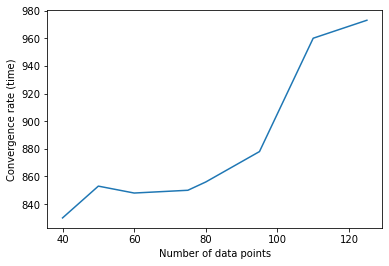

In [27]:
x = [125,110 ,95 ,80, 75 ,60 ,50, 40]
y = [973 ,960, 878, 856, 850 ,848 ,853, 830]
plt.plot(x,y)
plt.xlabel("Number of data points")
plt.ylabel("Convergence rate (time)")